In [1]:
import urllib
import os
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import ipywidgets as widgets



In [2]:
FILES_URL = 'https://datasette.planning.data.gov.uk/'

def download_dataset(dataset, output_dir_path, overwrite=False):
    dataset_file_name = f'{dataset}.db'
    
    if not os.path.exists(output_dir_path):
        os.makedirs(output_dir_path)
    
    output_file_path = os.path.join(output_dir_path, dataset_file_name)

    if overwrite is False and os.path.exists(output_file_path):
        return
    
    final_url = os.path.join(FILES_URL, dataset_file_name)
    print(f'downloading data from {final_url}')
    print(f'to: {output_file_path}')
    urllib.request.urlretrieve(final_url, os.path.join(output_dir_path, dataset_file_name))
    print('download complete')

In [3]:
def query_sqlite(db_path, query_string):

    with sqlite3.connect(db_path) as con:
            
        cursor = con.execute(query_string)
        cols = [column[0] for column in cursor.description]
        results_df = pd.DataFrame.from_records(data=cursor.fetchall(), columns=cols)

    return results_df

In [4]:

def datasette_query(db, sql_string):
    params = urllib.parse.urlencode({
        "sql": sql_string,
        "_size": "max"
        })
    url = f"https://datasette.planning.data.gov.uk/{db}.csv?{params}"
    df = pd.read_csv(url)
    return df

def get_issue_lookup():
    
    q = """
    select issue_type, severity, responsibility
    from issue_type
"""
    return datasette_query("digital-land", q)

In [5]:
data_dir = "../../data/db_downloads/"
os.makedirs(data_dir, exist_ok=True)

## Get data

In [6]:
download_dataset("performance", data_dir, overwrite=True)
# download_dataset("article-4-direction-area", data_dir, overwrite=True)
# download_dataset("tree-preservation-zone", data_dir, overwrite=True)

downloading data from https://datasette.planning.data.gov.uk/performance.db
to: ../../data/db_downloads/performance.db
download complete


In [7]:
lookup_issue_qual = pd.read_csv("data/issue_type_quality.csv")

## Analysis

In [8]:
subset_odp = ["conservation-area", "conservation-area-document", "article-4-direction-area", "article-4-direction", "listed-building-outline", "tree", "tree-preservation-zone", "tree-preservation-order"]
subset_bfl = ["brownfield-land"]
subset_dvl = ["developer-agreement", "developer-agreement-contribution", "developer-agreement-transaction"]

In [9]:
# BASE TABLE

# get table of active endpoints and resources, with issue summaries per resource joined on
q = f"""
    SELECT 
        rhe.organisation, rhe.name as organisation_name, rhe.collection, rhe.pipeline, rhe.endpoint, rhe.resource, rhe.latest_status, rhe.endpoint_entry_date, rhe.resource_start_date, 
        CAST(JULIANDAY('now') - JULIANDAY(rhe.resource_start_date) AS int) as resource_age_days,
        its.issue_type, its.count_issues, its.severity, its.responsibility
    FROM reporting_historic_endpoints rhe
    LEFT JOIN endpoint_dataset_issue_type_summary its on rhe.resource = its.resource
    WHERE 1=1
        AND rhe.endpoint_end_date = ""
        AND rhe.resource_end_date = ""
        AND rhe.latest_status = 200
"""

ep_res_issues = query_sqlite(os.path.join(data_dir, "performance.db"), q)

print(len(ep_res_issues))
ep_res_issues.head()

2891


,organisation,organisation_name,collection,pipeline,endpoint,resource,latest_status,endpoint_entry_date,resource_start_date,resource_age_days,issue_type,count_issues,severity,responsibility
0,development-corporation:Q20648596,Old Oak and Park Royal Development Corporation,brownfield-land,brownfield-land,a16e45dbefe2d67a6d27c086768b6c3610d4e057bb1962...,f1e218c96f99e378fdbaed9a426c6b44d0e7d3b5fec63e...,200,2019-12-01,2019-12-01,1804,patch,1.0,info,internal
1,development-corporation:Q20648596,Old Oak and Park Royal Development Corporation,brownfield-land,brownfield-land,a16e45dbefe2d67a6d27c086768b6c3610d4e057bb1962...,f1e218c96f99e378fdbaed9a426c6b44d0e7d3b5fec63e...,200,2019-12-01,2019-12-01,1804,default-field,41.0,info,internal
2,government-organisation:D1342,"Ministry of Housing, Communities & Local Gover...",area-of-outstanding-natural-beauty,area-of-outstanding-natural-beauty,34167c688ca765477c47e63592ff9149bb46710a0850f6...,d4f9a4c7d1bda9026c2079812c5f2fc9e6de231b111b7e...,200,2022-09-10,2024-10-03,36,None,NaN,None,None
3,government-organisation:D1342,"Ministry of Housing, Communities & Local Gover...",article-4-direction,article-4-direction-rule,e5598a75328d5890efb7e6d8bb6c1d181fbed2cda45af2...,44938e5a202309da506987cb84eb51fe789993f0870a9a...,200,2022-10-11,2022-10-25,745,None,NaN,None,None
4,government-organisation:D1342,"Ministry of Housing, Communities & Local Gover...",conservation-area,conservation-area,10e4c16fddeb43fe3a1f2d612ffc12418a6bac2ef28782...,c567bc3c40dcc06d7cc9048e6bb4b86ceae58274ccb963...,200,2024-10-17,2024-10-25,14,None,NaN,None,None


### Data quality view

In [10]:
# FRESHNESS TABLE

# create table of old resources and flag quality level as 5
ep_res_fresh_qual = ep_res_issues[ep_res_issues["resource_age_days"] > 365][["collection", "pipeline", "organisation", "organisation_name"]]

ep_res_fresh_qual["issue_type"] = "not_fresh"
ep_res_fresh_qual["quality_category"] = "1 - endpoint not updated in last year"
ep_res_fresh_qual["quality_level"] = 1

In [11]:
# ISSUES TABLE

# join on quality key and restrict fields
ep_res_issues_qual = ep_res_issues.merge(
    lookup_issue_qual[["issue_type", "quality_category", "quality_level"]],
    how = "left",
    on = "issue_type"
)[["collection", "pipeline", "organisation", "organisation_name", "issue_type", "quality_category", "quality_level"]]

# ep_res_issues_qual = ep_res_issues_qual[ep_res_issues_qual["issue_type"].notnull()]

print(len(ep_res_issues))
print(len(ep_res_issues_qual))

# ep_res_issues_qual.head()

2891
2891


In [12]:
# ALL QUALITY CATEGORIES TABLE
# concat tables for each type
ep_res_qual_all = pd.concat([ep_res_issues_qual, ep_res_fresh_qual])


In [13]:
# SCORING
# summarise by provision, taking max quality level for each
qual_summary = ep_res_qual_all.groupby([
    "collection", "pipeline", "organisation", "organisation_name"
    ],
as_index=False
).agg(
    quality_level = ("quality_level", "min")
)

qual_summary.replace(np.nan, 4, inplace=True)

level_map = {
    4: "4. excellent",
    3: "3. good for ODP",
    2: "2. improve",
    1: "1. update"}

qual_summary["quality_level_label"] = qual_summary["quality_level"].map(level_map)

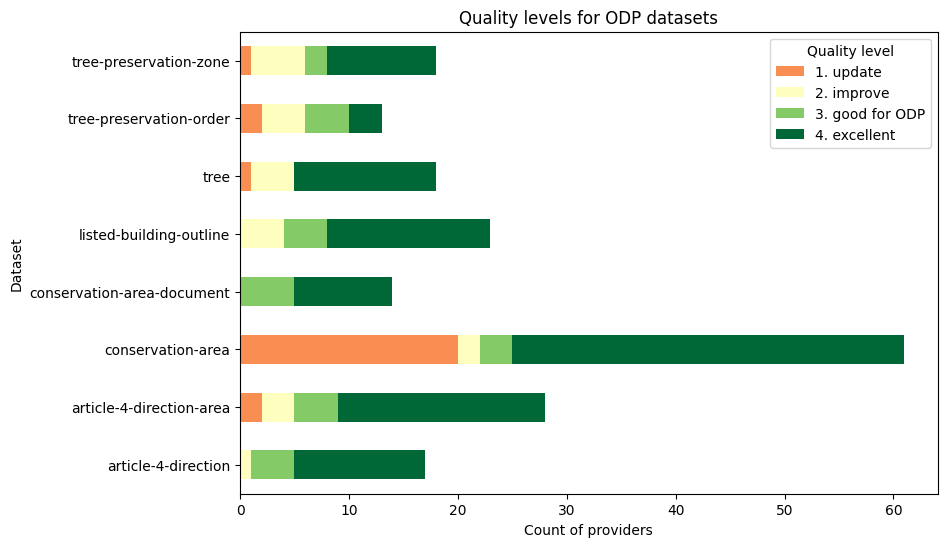

In [14]:
# VISUALISE

qual_summary_subset = qual_summary[qual_summary["pipeline"].isin(subset_odp)]
# qual_summary_subset = qual_summary[qual_summary["pipeline"].isin(subset_bfl)]
# qual_summary_subset = qual_summary[qual_summary["pipeline"].isin(subset_dvl)]

# color map to use in chart
cmap = plt.get_cmap('RdYlGn')
colors = [cmap(i / 4) for i in np.arange(1, 5)]

# count providers by dataset & quality level
qual_chart = qual_summary_subset.groupby(["pipeline", "quality_level", "quality_level_label"], as_index=False).agg(
    n_providers = ("quality_level", "count")
)

qual_chart.sort_values(["pipeline", "quality_level_label"], inplace=True)
qual_chart.pivot(columns = "quality_level_label", values = "n_providers", index = "pipeline").plot.barh(stacked = True, color = colors, figsize = (9, 6))

# Add labels and title
plt.xlabel('Count of providers')
plt.ylabel('Dataset')
plt.title('Quality levels for ODP datasets')
plt.legend(title='Quality level')

plt.show()

In [15]:
# qual_chart.to_csv("output/quality_summary_ODP_2024-11-06.csv", index = False)

#### Quality tables

In [16]:
# count issues by the quality category key
qual_cat_count = ep_res_qual_all.groupby(
        ["pipeline", "organisation", "organisation_name", "quality_category"],
        as_index=False
    ).agg(
        n_issues = ("quality_level", "count")
    )

In [17]:
# create a base table with each quality category key for each provision
prov = ep_res_qual_all[["pipeline", "organisation", "organisation_name"]].drop_duplicates()
prov["key"] = 1

qual_cat = ep_res_qual_all[ep_res_qual_all["quality_category"].notnull()][["quality_category"]].drop_duplicates()
qual_cat["key"] = 1

qual_cat_summary = prov.merge(
    qual_cat,
    how = "left",
    on = "key"
)
print(len(qual_cat_summary))

# left join on the counts to the base table
qual_cat_summary = qual_cat_summary.merge(
    qual_cat_count,
    how = "left",
    on = ['pipeline', 'organisation', 'organisation_name', 'quality_category']
)

# create boolean flag for each category
qual_cat_summary["issue_flag"] = np.where(qual_cat_summary["n_issues"] > 0, True, False)
print(len(qual_cat_summary))
qual_cat_summary.head()

3485
3485


,pipeline,organisation,organisation_name,key,quality_category,n_issues,issue_flag
0,brownfield-land,development-corporation:Q20648596,Old Oak and Park Royal Development Corporation,1,3 - any other validity error,NaN,False
1,brownfield-land,development-corporation:Q20648596,Old Oak and Park Royal Development Corporation,1,2 - unknown entity issues,NaN,False
2,brownfield-land,development-corporation:Q20648596,Old Oak and Park Royal Development Corporation,1,2 - geometry errors,NaN,False
3,brownfield-land,development-corporation:Q20648596,Old Oak and Park Royal Development Corporation,1,2 - duplicate reference values,NaN,False
4,brownfield-land,development-corporation:Q20648596,Old Oak and Park Royal Development Corporation,1,1 - endpoint not updated in last year,2.0,True


In [18]:

level_colours = {
    "1. excellent" : "background-color: #1a6837",
    "2. good for ODP" : "background-color: #87cb67",
    "3. improve" : "background-color: #fefebf",
    "4. update" : "background-color: #f78c51"
    }

flag_colours = {
    True : "color:red",
    False : "color:green"
    }

def make_color_mask(df):
    #DataFrame with same index and columns names as original filled empty strings
    df_color_map =  pd.DataFrame("", index=df.index, columns=df.columns)
    # turn label column into colours
    df_color_map["quality_level_label"] = df["quality_level_label"].map(level_colours)

    flag_slice = df.columns[3:-1]
    for s in flag_slice:
        df_color_map[s] = df[s].map(flag_colours)

    return df_color_map


def get_dataset_lpa_summary(dataset):
    """
    Given a dataset, will get a dataset subset from qual_cat_summary, 
    pivot it to have each quality category as a column, and then join
    on the overall quality score from qual_summary.
    """

    # subset and pivot
    df_wide = qual_cat_summary[
        qual_cat_summary["pipeline"] == dataset
    ].pivot(
        columns = "quality_category",
        values = "issue_flag",
        index = ["pipeline", "organisation", "organisation_name"]
    ).reset_index()

    # join on the quality category for the provision
    df_wide_flagged = df_wide.merge(
        qual_summary[["pipeline", "organisation", "quality_level_label"]],
        how = "left",
        on = ["pipeline", "organisation"]
    )

    return df_wide_flagged.style.apply(make_color_mask, axis=None)



In [22]:

dataset_list = qual_cat_summary["pipeline"].sort_values().drop_duplicates().values

dataset_dropdown = widgets.Dropdown(
    options = dataset_list,
    # value = dataset_list[0],
    description = "Select Dataset: ",
)

widgets.interact(get_dataset_lpa_summary, dataset = dataset_dropdown)

interactive(children=(Dropdown(description='Select Dataset: ', options=('agricultural-land-classification', 'a…

<function __main__.get_dataset_lpa_summary(dataset)>

In [20]:
get_dataset_lpa_summary("tree")

,pipeline,organisation,organisation_name,1 - endpoint not updated in last year,2 - duplicate reference values,2 - geometry errors,2 - unknown entity issues,3 - any other validity error,quality_level_label
0,tree,local-authority:BNE,London Borough of Barnet,False,False,False,False,False,4. excellent
1,tree,local-authority:BST,Bristol City Council,False,False,False,False,False,4. excellent
2,tree,local-authority:BUC,Buckinghamshire Council,False,False,False,False,False,4. excellent
3,tree,local-authority:DNC,Doncaster Metropolitan Borough Council,False,False,False,False,False,4. excellent
4,tree,local-authority:DOV,Dover District Council,False,False,False,False,False,4. excellent
5,tree,local-authority:EPS,Epsom and Ewell Borough Council,False,False,False,False,False,4. excellent
6,tree,local-authority:GAT,Gateshead Metropolitan Borough Council,False,False,False,False,False,4. excellent
7,tree,local-authority:GLO,Gloucester City Council,False,False,False,False,False,4. excellent
8,tree,local-authority:HOR,Horsham District Council,False,True,False,False,False,2. improve
9,tree,local-authority:LBH,London Borough of Lambeth,False,True,False,True,True,2. improve


#### Quality investigations

In [ ]:
qual_summary_subset[qual_summary_subset["pipeline"] == "tree"]

In [ ]:
qual_chart.groupby(["quality_level", "quality_level_label"], as_index = False).agg(
    total = ("n_providers", "sum")
)

In [ ]:
# Check some specifics - conservation area "update"

dataset = "conservation-area"
level = 4

level_provisions = ep_res_qual_all[
    (ep_res_qual_all["pipeline"] == dataset) & 
    (ep_res_qual_all["quality_level"] == level)][
        ["pipeline", "organisation"]
    ].drop_duplicates()

level_prov_all_issues = level_provisions.merge(
    ep_res_qual_all,
    how = "left", 
    on = ["pipeline", "organisation"]
    )

level_prov_all_issues[level_prov_all_issues["quality_level"].notnull()].drop_duplicates().groupby(["issue_type"], as_index=False).size()

In [ ]:
# Check some specifics - conservation area "update"

dataset = "tree-preservation-zone"
level = 3

level_provisions = qual_summary[
    (qual_summary["pipeline"] == dataset) & 
    (qual_summary["quality_level"] == level)][
        ["pipeline", "organisation"]
    ].drop_duplicates()

level_prov_all_issues = level_provisions.merge(
    ep_res_qual_all,
    how = "left", 
    on = ["pipeline", "organisation"]
    )

level_prov_all_issues[level_prov_all_issues["quality_level"].notnull()].drop_duplicates().groupby(["issue_type"], as_index=False).size()

### Provision view

In [ ]:
prov_summary_now = ep_res_issues[["organisation", "organisation_name", "collection", "pipeline"]].drop_duplicates().groupby(
    ["collection", "pipeline"], as_index=False
    ).agg(
    n_providers = ("organisation", "size")
)

prov_summary_now.head(10)

In [ ]:
# get table of active endpoints and resources, with issue summaries per resource joined on
q = f"""
    SELECT 
        organisation, organisation_name, dataset, active_endpoint_count,
        CASE WHEN active_endpoint_count > 0 then 1 else 0 end as active_endpoint_flag
    FROM provision_summary 
"""

prov_all = query_sqlite(os.path.join(data_dir, "performance.db"), q)
prov_all

#### Current

In [ ]:
prov_summary_now = prov_all.groupby(
    ["dataset"], as_index=False
    ).agg(
    n_providers = ("active_endpoint_flag", "sum"),
    n_expected = ("active_endpoint_flag", "size")
)

prov_summary_now["trusted_data"] = prov_summary_now["n_providers"]
prov_summary_now["no_data"] = prov_summary_now["n_expected"] - prov_summary_now["n_providers"]

prov_summary_now.head()

In [ ]:
prov_summary_chart = prov_summary_now[prov_summary_now["dataset"].isin(subset_odp)]

prov_summary_chart[["dataset", "trusted_data", "no_data"]].plot.bar(x = "dataset", stacked = True, color = ["black", "#d4d4d4"])

plt.ylabel('n providers')
plt.title(f'Current provision for ODP datasets')
plt.legend(title='Data type')
plt.show()

#### Historic

In [ ]:
def get_active_endpoints(dataset, date):

    q = f"""
        select distinct pipeline as dataset, name, DATE('{date}') as active_date, endpoint_entry_date, endpoint_end_date
        from reporting_historic_endpoints 
        where
            pipeline = '{dataset}'
            and endpoint_entry_date <= DATE('{date}')
            and (
                endpoint_end_date > DATE('{date}')
                or endpoint_end_date = "")
"""
    
    df = query_sqlite(os.path.join(data_dir, "performance.db"), q)

    return df

# test = get_active_endpoints("tree-preservation-zone", "2024-07-11")
# test

In [ ]:
dataset = "brownfield-land"

date_range = pd.date_range(end = "20241001", periods = 24, freq = "MS").format("%Y-%m-%d")

prov_hist = [get_active_endpoints(dataset, d) for d in date_range[1:-1]]
prov_hist_df = pd.concat(prov_hist)

prov_summary_hist = prov_hist_df[["dataset", "name", "active_date"]].drop_duplicates().groupby(["active_date", "dataset"], as_index = False).agg(
    n_providers = ("dataset", "size")
)

print(len(prov_summary_hist))
prov_summary_hist = prov_summary_hist.merge(
    prov_summary_now[["dataset", "n_expected"]],
    how = "left",
    on = "dataset"
)

prov_summary_hist["trusted_data"] = prov_summary_hist["n_providers"]
prov_summary_hist["no_data"] = prov_summary_hist["n_expected"] - prov_summary_hist["n_providers"]

print(len(prov_summary_hist))
# prov_summary_hist
prov_summary_hist[["dataset", "active_date", "trusted_data", "no_data"]].plot.area(x = "active_date", stacked = True, color = ["black", "#d4d4d4"])

plt.xlabel('date')
plt.ylabel('n providers')
plt.title(f'Historic provision for: {dataset}')
plt.legend(title='Data type')
plt.show()